# NCAA March Madness Predictions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data
import numpy as np
from statistics import mean

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

%matplotlib inline

The dataset shown below is a mix of ESPN and Ken Pom's basketball statistics. Quite a bit of work has already been done to clean and merge the data, as well as find the best predictors. Using this data, I will try to identify the optimal statistical method to predict the outcome of future games.  

In [2]:
NCAA = pd.read_csv(r"C:/Users/ia767/Documents/NCAA_big.csv")

In [3]:
NCAA.head()

,Unnamed: 0,Team_1,Team_2,Score_Gap,Win,RK_1,BPI_1,BPI_OFF_1,BPI_DEF_1,Wins_1,...,Luck_2,X13_2,AdjEM_1_2,X15_2,OppO_2,X17_2,OppD_2,X19_2,AdjEM_2_2_2,X21_2
0,1,Virginia,UMBC,-20,0,2,20.2,7.0,13.2,31,...,0.125,2,-4.38,269,102.7,267,107.1,259,-3.55,277
1,2,Creighton,Kansas State,-10,0,24,12.2,8.1,4.1,21,...,0.071,31,9.39,34,111.0,14,101.6,59,-6.50,324
2,3,Kentucky,Davidson,5,1,19,12.9,7.0,5.9,26,...,-0.063,318,2.11,104,105.6,116,103.5,91,1.33,121
3,4,Arizona,Buffalo,-21,0,26,11.9,9.4,2.5,27,...,0.006,158,-0.06,140,105.1,145,105.2,147,3.87,62
4,5,UMBC,Kansas State,-7,0,156,0.7,-0.2,0.9,25,...,0.071,31,9.39,34,111.0,14,101.6,59,-6.50,324


The two variables below were selected elsewhere using forward subset selection.

In [4]:
y = NCAA['Win']
X = NCAA[["BPI_DEF_1", "Wins_2"]]

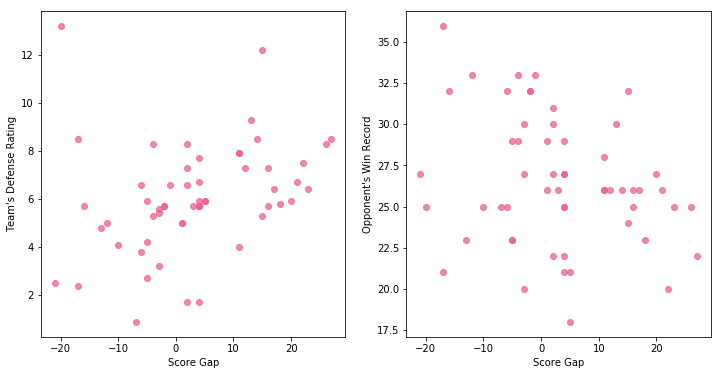

In [5]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6)) 
ax[0].scatter(NCAA['Score_Gap'], NCAA["BPI_DEF_1"], color = "#ea5f94", alpha = 0.75) 
ax[1].scatter(NCAA['Score_Gap'], NCAA["Wins_2"], color = "#ea5f94", alpha = 0.75) 
ax[0].set_xlabel("Score Gap")
ax[0].set_ylabel("Team's Defense Rating")
ax[1].set_xlabel("Score Gap")
ax[1].set_ylabel("Opponent's Win Record")
plt.show()

## Model Selection

The first model I run is Logistic Regression.

In [6]:
logreg = LogisticRegression().fit(X, y) #using default C
print("Test set score: {:.2f}".format(logreg.score(X, y)))
print("CV Test Score: {:.2f}".format( np.mean(cross_val_score(logreg, X, y, cv=10))) )

Test set score: 0.73
CV Test Score: 0.72


In [7]:
from sklearn import preprocessing

In [8]:
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [9]:
logreg_scaled = LogisticRegression().fit(X_scaled, y) #using default C
print("Test set score: {:.2f}".format(logreg_scaled.score(X_scaled, y)))
print("CV Test Score: {:.2f}".format( np.mean(cross_val_score(logreg_scaled, X_scaled, y, cv=10))) )

Test set score: 0.70
CV Test Score: 0.71


In [10]:
param_grid = {'C': np.arange(0.1, 100, 5)} #goes from >0 to 100 (since 100 was baseline)

grid = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=10)

grid.fit(X, y) #finding best C

best_C = grid.best_params_["C"] #storing best C

logreg_bestC = LogisticRegression(C = best_C).fit(X, y) #using optimal C

print("Test set score: {:.2f}".format(logreg_bestC.score(X, y)))
print("CV Test Score: {:.2f}".format( np.mean(cross_val_score(logreg_bestC, X, y, cv=10))) )

Test set score: 0.75
CV Test Score: 0.72


The base logit model has as good a CV test score as any of its 'optimized' iterations.

The next model I try is K-Nearest Neighbors, using grid search to find the optimal value of K.

In [11]:
param_grid = {'n_neighbors': np.arange(1, 30, 2)}
grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=10)
grid.fit(X, y)

best_k = grid.best_params_["n_neighbors"] #storing best K

knn = KNeighborsClassifier(n_neighbors = best_k).fit(X, y)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("Test set score: {:.3f}".format(grid.score(X, y)))
print("CV Test Score: {:.2f}".format( np.mean(cross_val_score(knn, X, y, cv=10))) )

best mean cross-validation score: 0.768
best parameters: {'n_neighbors': 7}
Test set score: 0.857
CV Test Score: 0.77


The optimized KNN model improves on the Logit's test score by 5%.

I now turn to tree models, starting with a simple Decision Tree Classifier.

In [12]:
from sklearn.tree import DecisionTreeClassifier

tree_basic = DecisionTreeClassifier().fit(X, y)

print("Test set score: {:.3f}".format(tree_basic.score(X, y)))
print("CV Test Score: {:.2f}".format(np.mean(cross_val_score(tree_basic, X, y, cv=10))) )

Test set score: 1.000
CV Test Score: 0.69


In [13]:
from sklearn.ensemble import RandomForestClassifier

tree_rfc = RandomForestClassifier(n_estimators=200).fit(X, y)

print("Test set score: {:.3f}".format(tree_rfc.score(X, y)))
print("CV Test Score: {:.2f}".format(np.mean(cross_val_score(tree_rfc, X, y, cv=10))) )

Test set score: 1.000
CV Test Score: 0.75


In [14]:
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier() #Need to instantiate a model type for bagging first
tree_bag = BaggingClassifier(tree, n_estimators=100, 
                        random_state=1).fit(X, y)

print("Test set score: {:.3f}".format(tree_bag.score(X, y)))
print("CV Test Score: {:.2f}".format(np.mean(cross_val_score(tree_bag, X, y, cv=10))) )

Test set score: 1.000
CV Test Score: 0.75


Neither of these tree models improves on the KNN's score. 

I do take advantage of the tree models to look at the contribution of my independent variables.

In [15]:
print(tree_rfc.feature_importances_) 
X.columns

[ 0.53014213  0.46985787]


Index(['BPI_DEF_1', 'Wins_2'], dtype='object')

They seem to contribute about equally to the model's predictive power.

The final model I run is a Support Vector Machine. I first run a linear version, tuning its parameters, then a non-linear SVM. The parameter tuning of the non-linear SVM is somewhat limited because the code always runs very slowly.

In [16]:
from sklearn.svm import SVC 

param_grid = {'C': np.arange(1, 600, 20)}
grid = GridSearchCV(SVC(kernel = "linear"), param_grid=param_grid, cv=10)
grid.fit(X, y)

best_C = grid.best_params_["C"] #storing best C

svc_linear = SVC(kernel = "linear", C = best_C).fit(X, y)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("Test set score: {:.3f}".format(grid.score(X, y)))
print("CV Test Score: {:.2f}".format( np.mean(cross_val_score(svc_linear, X, y, cv=10))) )

best mean cross-validation score: 0.750
best parameters: {'C': 1}
Test set score: 0.750
CV Test Score: 0.74


In [17]:
param_grid = {'C': np.arange(1, 600, 10), 
             'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.015, 0.5]} #manual bc otherwise very slow
grid = GridSearchCV(SVC(kernel = "rbf", gamma = 0.001), param_grid=param_grid, cv=10)
grid.fit(X, y)

best_C = grid.best_params_["C"]

svc = SVC(kernel = "rbf", C = best_C, gamma = 0.001).fit(X, y)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("Test set score: {:.3f}".format(grid.score(X, y)))
print("CV Test Score: {:.2f}".format( np.mean(cross_val_score(svc, X, y, cv=10))) )

best mean cross-validation score: 0.821
best parameters: {'C': 141, 'gamma': 0.015}
Test set score: 0.893
CV Test Score: 0.76


The problem with this approach is that the GridSearch picks the best **Test** set score. Playing around with values manually actually yields better results.

In [18]:
svc = SVC(kernel = "rbf", C = 600, gamma = 0.01).fit(X, y)

print("Test set score: {:.3f}".format(svc.score(X, y)))
print("CV Test Score: {:.2f}".format( np.mean(cross_val_score(svc, X, y, cv=10))) )

Test set score: 0.875
CV Test Score: 0.82


The code below optimizes the SVC based on test score instead:

In [19]:
scores = []

for i in np.arange(1, 600, 10): 
    model = SVC(kernel = "rbf", C = i, gamma = 0.01).fit(X, y)
    cv_score = np.mean(cross_val_score(model, X, y, cv=10))
    scores.append(cv_score)
    
scores.index(max(scores)) #finding position of max
print("Optimal C: {}".format(np.arange(1, 600, 10)[scores.index(max(scores))])) #finding optimal value of C
print("Best CV Test Score: {}".format(round(max(scores), 2))) #finding best score

Optimal C: 291
Best CV Test Score: 0.82


The optimized SVC improves on our previous best test score by 5%. It is therefore the model I keep for prediction purposes.

### Prediction 

The dataset below contains all of the same information as our training set, updated for 2019.

In [20]:
NCAA_19 = pd.read_csv(r"C:/Users/ia767/Documents/NCAA_big_19.csv")
NCAA_19.head()

,Unnamed: 0,Team_1,Team_2,RK_1,CONF_1,W-L_1,BPI_OFF_1,BPI_DEF_1,BPI_1,7-DAY_RK CHG_1,...,Luck_2,X13_2,AdjEM_1_2,X15_2,OppO_2,X17_2,OppD_2,X19_2,AdjEM_2_2_2,X21_2
0,1,Duke,Virginia Tech,3,ACC,31-5,10.9,10.6,21.5,--,...,0.011,156,8.07,53,108.1,54,100.1,44,-6.12,325
1,2,LSU,Michigan State,20,SEC,28-6,8.5,4.4,12.9,3,...,-0.006,196,12.87,4,110.2,13,97.4,5,3.15,87
2,3,Virginia,Oregon,1,ACC,31-3,11.8,11.6,23.4,--,...,-0.038,268,4.91,70,107.5,64,102.6,87,0.36,153
3,4,Purdue,Tennessee,9,Big Ten,25-9,11.0,6.4,17.4,1,...,0.047,68,10.18,27,109.5,27,99.3,30,0.96,131
4,5,Florida State,Gonzaga,14,ACC,29-7,6.3,8.5,14.8,2,...,0.009,162,3.40,85,106.7,75,103.3,104,1.98,102


In [21]:
SVC(kernel = "rbf", C = 291, gamma = 0.01).fit(X, y).predict(NCAA_19[["BPI_DEF_1", "Wins_2"]])

array([1, 1, 1, 0, 0, 1, 1, 1], dtype=int64)

This yields my predictions for the upcoming games. The output is "1" if team 1 is predicted to win and 0 otherwise. That is: Duke will win against VT, LSU against Michigan State, etc.

In [22]:
NCAA_19["preds"] = SVC(kernel = "rbf", C = 291, gamma = 0.01).fit(X, y).predict(NCAA_19[["BPI_DEF_1", "Wins_2"]])
NCAA_19[["Team_1", 'Team_2', "preds"]]

,Team_1,Team_2,preds
0,Duke,Virginia Tech,1
1,LSU,Michigan State,1
2,Virginia,Oregon,1
3,Purdue,Tennessee,0
4,Florida State,Gonzaga,0
5,Texas Tech,Michigan,1
6,Houston,Kentucky,1
7,Auburn,North Carolina,1


## Adding Variables

Which variables could I add to the model to improve my prediction?

I use correlation with our dependent variable as a selection criterion. I also choose variables with low correlation with my current dependent variables to make sure they will contribute to my prediction model.

In [23]:
NCAA.corr()[["Win", "BPI_DEF_1", "Wins_2"]][(abs(NCAA.corr()["Win"]) > abs(0.2)) & (abs(NCAA.corr()["BPI_DEF_1"]) < abs(0.35))
                                           & (abs(NCAA.corr()["Wins_2"]) < abs(0.35))]

,Win,BPI_DEF_1,Wins_2
Unnamed: 0,0.201331,0.157051,-0.042503
Score_Gap,0.784962,0.306255,-0.259920
Win,1.000000,0.267286,-0.302102
Wins_1,0.349615,0.346597,0.037474
AdjEM_1_1_1,0.210072,0.303083,-0.142803
OppD_1,-0.228382,-0.218900,0.118188
X19_1,-0.241566,-0.272801,0.105683
Luck_2,-0.241174,0.137012,0.154525
X13_2,0.229904,-0.091662,-0.186480
AdjEM_2_2_2,0.298900,0.122751,-0.099345


This gives us quite a bit of choice when it comes to our new variables. The code below finds the new test CV for the selected non-linear model for every one of these variables.

The new variables I'm considering are below.

In [24]:
NCAA.corr()[["Win", "BPI_DEF_1", "Wins_2"]][(abs(NCAA.corr()["Win"]) > abs(0.2)) & (abs(NCAA.corr()["BPI_DEF_1"]) < abs(0.35))
                                           & (abs(NCAA.corr()["Wins_2"]) < abs(0.35))].index[4:]

Index(['AdjEM_1_1_1', 'OppD_1', 'X19_1', 'Luck_2', 'X13_2', 'AdjEM_2_2_2',
       'X21_2'],
      dtype='object')

In [25]:
x = NCAA.corr()[["Win", "BPI_DEF_1", "Wins_2"]][(abs(NCAA.corr()["Win"]) > abs(0.2)) & (abs(NCAA.corr()["BPI_DEF_1"]) < abs(0.35))
                                           & (abs(NCAA.corr()["Wins_2"]) < abs(0.35))].index[4:] #possible variables
initial = ["BPI_DEF_1", "Wins_2"]

for i in range(0, len(x)):
    initial = ["BPI_DEF_1", "Wins_2"]
    initial.append(x[i])
    X = NCAA[initial]
    svc = SVC(kernel = "rbf", C = 291, gamma = 0.01).fit(X, y)
    print(x[i])
    print("CV Test Score: {:.2f}".format( np.mean(cross_val_score(svc, X, y, cv=10))) )

AdjEM_1_1_1
CV Test Score: 0.76
OppD_1
CV Test Score: 0.73
X19_1
CV Test Score: 0.68
Luck_2
CV Test Score: 0.80
X13_2
CV Test Score: 0.52
AdjEM_2_2_2
CV Test Score: 0.76
X21_2
CV Test Score: 0.63


None of these variables actually improve the model. It seems like Luck_2 is the 'best' of the batch, but it is essentially a residual (and might not carry over for another year), so I'll focus on AdjEM_1_1_1 & AdjEM_2_2_2 for now. (The model was tuned using a different set of variables, so maybe the 'optimized' performance will be better).

In [26]:
X = NCAA[["BPI_DEF_1", "Wins_2", "AdjEM_1_1_1"]]
scores = []

for i in np.arange(1, 600, 10): 
    model = SVC(kernel = "rbf", C = i, gamma = 0.01).fit(X, y)
    cv_score = np.mean(cross_val_score(model, X, y, cv=10))
    scores.append(cv_score)
    
scores.index(max(scores)) #finding position of max
print("Optimal C: {}".format(np.arange(1, 600, 10)[scores.index(max(scores))])) #finding optimal value of C
print("Best CV Test Score: {}".format(round(max(scores), 2))) #finding best score

Optimal C: 91
Best CV Test Score: 0.77


In [27]:
X = NCAA[["BPI_DEF_1", "Wins_2", "AdjEM_2_2_2"]]
scores = []

for i in np.arange(1, 600, 10): 
    model = SVC(kernel = "rbf", C = i, gamma = 0.01).fit(X, y)
    cv_score = np.mean(cross_val_score(model, X, y, cv=10))
    scores.append(cv_score)
    
scores.index(max(scores)) #finding position of max
print("Optimal C: {}".format(np.arange(1, 600, 10)[scores.index(max(scores))])) #finding optimal value of C
print("Best CV Test Score: {}".format(round(max(scores), 2))) #finding best score

Optimal C: 201
Best CV Test Score: 0.78


Neither actually improves the model.